# Code for Classifiers Trained using July Dataset


---


This notebook includes code for creating the classifier(s) trained for the paper:

Specifically, this notebook includes the necessary code to:

1. Aggregate and label the raw data. (These may be saved to CSV files and reloaded.) This involved:
    1. Loading the raw data acquired from the plasma gun.
    2. Concatenating the raw optical emission spectra (OES) data from separate samples.
    3. Generating small images representing the Lissajous (charge-voltage, Q-V) figures from the raw electrical waveforms.
2. Generate the training/validation/testing datasets. This involved:
    1. Selecting particular ranges of the raw data corresponding to distinct intensity peaks of the optical emission spectra (OES).
    2. Converting the generated images to flattened arrays.
    3. (optional) Concatenating the electrical data (flattened Q-V figures) with the chemical data (OES)
    4. Splitting the data into training/validation/test sets.
3. Train and test classifier(s). This involved:
    1. For Decision Tree, Random Forest, and K Nearest Neighbor, finding the optimal hyperparameter(s) based on the training/validation sets and a 5-fold cross-validation strategy.
    2. For Neural Network, building a feedforward, fully-connected neural network with dropout and training with model checkpoints to save weights based on validation loss.
    3. For all models, evaluating the data on the test set and creating confusion matrices.

## Library Importation and Setup

In [ ]:
# Library Importation:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import keras
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint
import os
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
# Define function for confusion matrices in results section:
from sklearn.metrics import ConfusionMatrixDisplay
def create_confusion_matrix(true_labels, pred_labels, labels=["skin","muscle","bone","fat"],colorbar=False):
    fig, ax = plt.subplots(1,1, dpi=300)
    cfmDisplay = ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels,
                                            display_labels=["skin","muscle","bone","fat"],
                                            cmap="Greys", labels=labels, ax=ax,
                                            colorbar=colorbar)
    return cfmDisplay

In [ ]:
# base_path = "/content/drive/MyDrive/" # Kelci
base_path = "/content/drive/MyDrive/Research/Berkeley-France/" # Kimberly

## Part 1: Initial Processing of Raw Data

In [ ]:
# Define folder path where the raw data is located:
# path = f"{base_path}Mesbah Lab/Fall 2023 Tissue Differentiation/Plasma Detector (Copy)/June-July 2023 (All 600 Hz)"
path = "./data/0-raw_data"

# Provide a save file label:
File_label = "IndividualTimes(NoR)" #@param{type:"string"}

# Provide data collection information:
background_recorded = True #@param{type:"boolean"}

# Change directory:
os.chdir(path)

# List of anomalous data found during visual examination:
Bad_list = [
    "2023_06_09_12h13m41s_chicken P_skin1",
    "2023_06_09_12h41m37s_chicken P_bone2",
    "2023_06_09_12h43m20s_chicken P_bone3",
    "2023_06_09_13h09m42s_chicken Q_bone1",
    "2023_07_24_16h33m01s_chicken S_fat1",
    "2023_07_24_16h35m22s_chicken S_fat2",
    "2023_07_24_17h55m14s_chicken U_skin2",
    "2023_07_24_18h02m46s_chicken U_muscle2",
    "2023_07_24_18h04m44s_chicken U_muscle3",
    "2023_07_24_18h08m39s_chicken U_fat1",
    "2023_07_24_18h15m46s_chicken U_bone1",
    "2023_07_25_10h38m50s_chicken V_fat4",
    "Chicken R - Not good",
]

### Aggregation and Labeling Raw Optical Emission Spectra (OES) Data

In [ ]:
# Create empty lists for storage:
Sample_list_OES = []
label = []
file_name = []

# Iterate through all files in directory:
for file in os.listdir():
    if os.path.isdir(file): # check if file is a folder (collected raw data exists in folders)
        if not (file in Bad_list): # Omit anomalous data identified above
            if not 'person' in file: # Omit non-chicken samples
                if not 'R' in file: # Omit chicken "R" due to poor quality of data
                    # Create file path for each sample:
                    file_path = f"{path}/{file}/data.h5"
                    # Upload input-output OES data measured with spectrometer:
                    S = pd.read_hdf(file_path, key="spec")
                    # Define the different OES measurements collected:
                    wavelengths = S.iloc[0,:].to_numpy()
                    background = S.iloc[1,:].to_numpy()
                    OES = S.iloc[2:,:].to_numpy()

                    # Split file name by the underscore:
                    split_file = file.split('_')
                    # Select last section of file name and remove last digit to create tissue type labels:
                    Tissue_type = split_file[-1]
                    tissue_name = Tissue_type[:-1]

                    # Remove samples with delayed starts (flatline samples):
                    for i in range(OES.shape[0]):
                        OES_sum = ((OES[i,:] - background).sum())
                        # Select only the samples with a sum of greater than 2000 a.u. of intensity:
                        if OES_sum > 2000:
                            # Append each individual time step sample with corresponding label and file name for OES DataFrame:
                            Sample_list_OES.append(OES[i,:] - background)
                            label.append(tissue_name)
                            file_name.append(file)


In [ ]:
# Create separate DataFrames to allow for data engineering step:
df = pd.DataFrame(Sample_list_OES, columns=wavelengths)
dfW = pd.DataFrame(wavelengths)
df_file = pd.DataFrame(file_name, columns=['Sample'])
df_labels = pd.DataFrame(label, columns=['Tissue Type'])

In [ ]:
# Concatenate file, label, and OES DataFrames:
Data = pd.concat([df_file, df_labels, df], axis = 1)
Data

,Sample,Tissue Type,198.74825,199.21617864146077,199.684085101722,200.15196937460223,200.61983145391994,201.08767133349366,201.55548900714183,202.02328446868296,...,1105.828521318483,1106.237716950683,1106.6468776801473,1107.0560035006934,1107.46509440614,1107.8741503903059,1108.2831714470096,1108.692157570069,1109.1011087533032,1109.5100249905304
0,2023_05_15_15h14m14s_chicken O_skin3,skin,4.0,-5.0,-1.0,3.0,14.0,-3.0,-4.0,-10.0,...,0.0,-2.0,18.0,5.0,15.0,-2.0,3.0,-10.0,-3.0,3.0
1,2023_05_15_15h14m14s_chicken O_skin3,skin,6.0,-6.0,8.0,3.0,5.0,-8.0,-13.0,56.0,...,-9.0,-4.0,16.0,5.0,2.0,-18.0,9.0,-4.0,0.0,5.0
2,2023_05_15_15h14m14s_chicken O_skin3,skin,0.0,5.0,6.0,1.0,21.0,-4.0,-7.0,42.0,...,-3.0,30.0,10.0,-3.0,4.0,-8.0,3.0,0.0,-1.0,1.0
3,2023_05_15_15h14m14s_chicken O_skin3,skin,2.0,1.0,2.0,0.0,5.0,-8.0,7.0,40.0,...,1.0,-4.0,8.0,5.0,-6.0,-6.0,7.0,0.0,3.0,0.0
4,2023_05_15_15h14m14s_chicken O_skin3,skin,3.0,2.0,2.0,6.0,3.0,-1.0,21.0,19.0,...,-9.0,6.0,-6.0,4.0,-4.0,-2.0,0.0,-6.0,-5.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11451,2023_07_25_16h15m57s_chicken Z_fat3,fat,0.0,5.0,0.0,1.0,-38.0,12.0,3.0,23.0,...,-18.0,3.0,-2.0,18.0,4.0,4.0,-1.0,11.0,0.0,2.0
11452,2023_07_25_16h15m57s_chicken Z_fat3,fat,6.0,0.0,0.0,3.0,-32.0,18.0,3.0,12.0,...,9.0,1.0,11.0,14.0,-11.0,8.0,2.0,5.0,-3.0,3.0
11453,2023_07_25_16h15m57s_chicken Z_fat3,fat,-3.0,4.0,4.0,2.0,-48.0,9.0,6.0,7.0,...,15.0,3.0,5.0,12.0,2.0,13.0,9.0,8.0,0.0,-1.0
11454,2023_07_25_16h15m57s_chicken Z_fat3,fat,0.0,3.0,2.0,5.0,-17.0,3.0,2.0,11.0,...,9.0,3.0,33.0,21.0,-8.0,4.0,2.0,9.0,0.0,0.0


In [ ]:
# Save each as .csv file using File_label defined above:
# Data.to_csv(f'{base_path}Mesbah Lab/Fall 2023 Tissue Differentiation/Data Files (csv)/CompleteOESDataWithLabelsJuly{File_label}2023.csv')
# dfW.to_csv(f'{base_path}Mesbah Lab/Fall 2023 Tissue Differentiation/Data Files (csv)/WavelenthsDataFrameJuly{File_label}2023.csv')
# df_file.to_csv(f'{base_path}Mesbah Lab/Fall 2023 Tissue Differentiation/Data Files (csv)/July{File_label}2023Files.csv')
# df_labels.to_csv(f'{base_path}Mesbah Lab/Fall 2023 Tissue Differentiation/Data Files (csv)/July{File_label}2023Labels.csv')
Data.to_csv(
    f"./data/1-aggregate_data/CompleteOESDataWithLabelsJuly{File_label}2023.csv"
)
dfW.to_csv(f"./data/1-aggregate_data/WavelenthsDataFrameJuly{File_label}2023.csv")
df_file.to_csv(
    f"./data/1-aggregate_data/July{File_label}2023Files.csv"
)
df_labels.to_csv(f"./data/1-aggregate_data/July{File_label}2023Labels.csv")

### Image Generation for Lissajous Figures from Raw Electrical Waveforms

In [ ]:
import matplotlib
matplotlib.use('agg') # use agg backend for colab to avoid crashing when generating lots of images

n = int(background_recorded)
# Iterate through all files in directory:
for file in os.listdir():
    if os.path.isdir(file):
        if not file in Bad_list: # Omit anomalous data
            if not 'person' in file: # Omit non-chicken samples
                if not 'R' in file: # Omit chicken "R" due to poor quality of data
                    # Create file path for each sample:
                    file_path = f"{path}/{file}/data.h5"

                    # Read raw electrical data:
                    osc_df = pd.read_hdf(file_path, key="osc")
                    chA = osc_df.iloc[1::3,:] # applied voltage measurement
                    chC = osc_df.iloc[3::3,:] # voltage measurement after compensation circuit
                    osc_df = []

                    # Read raw OES
                    S = pd.read_hdf(file_path, key="spec")
                    background = S.iloc[1,:] # second row is the background
                    OES = S.iloc[2:,:] # remainder of rows are OES during plasma operation
                    S = []

                    # Convert measured voltage signal to appropriate units and compute charge from given voltage and capacitance:
                    chA = chA * 1e-3 # [kV], applied voltage, corrected by factor of 1000, attenuation of probe: 1000x
                    chC = chC * 1e-2 * 0.2 # [nC], charge on target, corrected by a factor of 1000, attenuation of probe: 10x, voltage drop measured over 200pF capacitor

                    # Remove samples with delayed starts (flatline samples):
                    for i in range(OES.shape[0]):
                        OES_sum = ((OES.iloc[i,:] - background).sum())
                        # Select only the samples with a sum of greater than 2000 a.u. of intensity:
                        if OES_sum > 2000:
                            # Plot Lissajous figures matching corresponding OES data samples:
                            plt.figure(figsize=(0.8, 0.8))
                            plt.plot(chA.iloc[i,:], chC.iloc[i,:], 'k-', linewidth = 3)
                            plt.axis('off')
                            plt.gray()
                            plt.xlim(-2, 9)
                            plt.ylim(-10, 27)

                            # Save images as .jpg files:
                            # plt.savefig(f'{base_path}Mesbah Lab/Fall 2023 Tissue Differentiation/EM Images/EM Images July 2023/Channel A-C EM Images {File_label}/Lissajous_channel_A_C_{file}_iteration_{i}.jpg', facecolor='w')
                            plt.savefig(
                                f"./data/2-image_generation/Channel A-C EM Images {File_label}/Lissajous_channel_A_C_{file}_iteration_{i}.jpg",
                                facecolor="w",
                            )
                            plt.close("all")

## Part 2: Create Model Inputs (Train/Validation/Test Dataset Creation)

In [ ]:
# Enter the save file label (should be the same as used in Part 1 during saving):
File_label = "IndividualTimes(NoR)" #@param{type:"string"}

### Reduce Features of OES via Manual Peak Selection

In [ ]:
# read saved OES data
# Data = pd.read_csv(
#     f'{base_path}Mesbah Lab/Fall 2023 Tissue Differentiation/Data Files (csv)/CompleteOESDataWithLabelsJuly{File_label}2023.csv',
#     index_col=0,
# )
# Data.set_index("Sample", drop=False, inplace=True)
# # read saved wavelengths
# wavelengthsdf = pd.read_csv(
#     f'{base_path}Mesbah Lab/Fall 2023 Tissue Differentiation/Data Files (csv)/WavelenthsDataFrameJuly{File_label}2023.csv',
#     index_col=0,
# )

Data = pd.read_csv(
    f'./data/1-aggregate_data/CompleteOESDataWithLabelsJuly{File_label}2023.csv',
    index_col=0,
)
Data.set_index("Sample", drop=False, inplace=True)
# read saved wavelengths
wavelengthsdf = pd.read_csv(
    f'./data/1-aggregate_data/WavelenthsDataFrameJuly{File_label}2023.csv',
    index_col=0,
)

# Select relevant information from dataframes:
df_file = Data["Sample"]
df_labels = Data["Tissue Type"]
wavelengths = wavelengthsdf.to_numpy()
Data2 = Data.iloc[:,2:]

# Create wavelength range for UV region:
WaveHighUV1 = np.where(wavelengths > 290, True, False)
WaveLowUV1 = np.where(wavelengths < 430, True, False)
UltraV = np.logical_and(WaveLowUV1, WaveHighUV1)
dfUV = Data2.iloc[:,UltraV]

# Create 1st wavelength range found for skin:
WaveHighS1 = np.where(wavelengths > 447, True, False)
WaveLowS1 = np.where(wavelengths < 451, True, False)
WavelengthsS1 = np.logical_and(WaveLowS1, WaveHighS1)
dfS1 = Data2.iloc[:,WavelengthsS1]

# Create 2nd wavelength range found for skin:
WaveHighS2 = np.where(wavelengths > 456, True, False)
WaveLowS2 = np.where(wavelengths < 460, True, False)
WavelengthsS2 = np.logical_and(WaveLowS2, WaveHighS2)
dfS2 = Data2.iloc[:,WavelengthsS2]

# Create 3rd wavelength range found for skin:
WaveHighS3 = np.where(wavelengths > 469, True, False)
WaveLowS3 = np.where(wavelengths < 474, True, False)
WavelengthsS3 = np.logical_and(WaveLowS3, WaveHighS3)
dfS3 = Data2.iloc[:,WavelengthsS3]

# Create 4th wavelength range found for skin:
WaveHighS4 = np.where(wavelengths > 500, True, False)
WaveLowS4 = np.where(wavelengths < 505, True, False)
WavelengthsS4 = np.logical_and(WaveLowS4, WaveHighS4)
dfS4 = Data2.iloc[:,WavelengthsS4]

# Create wavelength range for Helium peaks:
WaveHigh2 = np.where(wavelengths > 700, True, False)
WaveLow2 = np.where(wavelengths < 715, True, False)
Wavelengths2 = np.logical_and(WaveLow2, WaveHigh2) # combines boolean arrays of same length where values are both either true or false
dfPeak2 = Data2.iloc[:, Wavelengths2]

# Create wavelenth range for 1st peak:
WaveHigh8001 = np.where(wavelengths > 842, True, False)
WaveLow8001 = np.where(wavelengths < 847, True, False)
Wavelengths8001 = np.logical_and(WaveLow8001, WaveHigh8001)
dfPeak842 = Data2.iloc[:,Wavelengths8001]

# Create wavelenth range for 2nd peak:
WaveHigh8002 = np.where(wavelengths > 867, True, False)
WaveLow8002 = np.where(wavelengths < 872, True, False)
Wavelengths8002 = np.logical_and(WaveLow8002, WaveHigh8002)
dfPeak867 = Data2.iloc[:,Wavelengths8002]

# Create wavelenth range for 3rd peak:
WaveHigh8003 = np.where(wavelengths > 886, True, False)
WaveLow8003 = np.where(wavelengths < 891, True, False)
Wavelengths8003 = np.logical_and(WaveLow8003, WaveHigh8003)
dfPeak886 = Data2.iloc[:,Wavelengths8003]

# Concatenate useful wavelength ranges, file, and label DataFrames:
OES_July = pd.concat(
    [df_file, df_labels, dfUV, dfS1, dfS2, dfS3, dfS4, dfPeak2, dfPeak842, dfPeak867, dfPeak886],
    axis=1,
    ignore_index=False,
)
sample_size = OES_July.shape[0]
# Print number of OES samples:
sample_size

11456

### Load and Flatten Image Arrays from Generated Lissajous Figures

In [ ]:
# Define folder path to upload EM images:
# path = f"{base_path}Mesbah Lab/Fall 2023 Tissue Differentiation/EM Images/EM Images July 2023/Channel A-C EM Images {File_label}"
path = f"./2-image_generation/Channel A-C EM Images {File_label}"

# Change directory:
os.chdir(path)

# Create empty list for images:
image_list = []
file_list = []

# Iterate through all files in directory:
for file in os.listdir():
    if file.endswith(('.jpg')): # Include only .jpg file types
        # Create file path for each sample:
        file_path = f"{path}/{file}"
        # Read files in path:
        img = mplimg.imread(file_path)
        # Flatten images and append to image list:
        image_list.append(img[:,:,0].flatten())

        split_file = file.split('_')
        file_list.append('_'.join(split_file[4:10]))

# Create DataFrame of flattened images:
df_July_images = pd.DataFrame(image_list, index=file_list)
df_July_images = pd.concat(
        [df_file, df_labels, df_July_images],
        axis=1,
        ignore_index=False,
    )
sample_size = df_July_images.shape[0]
# Print number of EM samples:
sample_size

11456

In [ ]:
# @title Save data to avoid having to regenerate them
# OES_July.to_hdf(f"{base_path}Mesbah Lab/model-inputs/july_data_processed_{File_label}.h5", key="oes")
# df_July_images.to_hdf(f"{base_path}Mesbah Lab/model-inputs/july_data_processed_{File_label}.h5", key="em_images")

OES_July.to_hdf(
    f"./data/3-model_inputs/july_data_processed_{File_label}.h5", key="oes"
)
df_July_images.to_hdf(
    f"./data/3-model_inputs/july_data_processed_{File_label}.h5",
    key="em_images",
)

### (Re)Load Data, [optional] Concatenate Chemical (OES) and Electrical (images) Data

In [ ]:
# OES_July = pd.read_hdf(f"{base_path}Mesbah Lab/model-inputs/july_data_processed_{File_label}.h5", key="oes")
# df_July_images = pd.read_hdf(f"{base_path}Mesbah Lab/model-inputs/july_data_processed_{File_label}.h5", key="em_images")
OES_July = pd.read_hdf(
    f"./data/3-model_inputs/july_data_processed_{File_label}.h5", key="oes"
)
df_July_images = pd.read_hdf(
    f"./data/3-model_inputs/july_data_processed_{File_label}.h5",
    key="em_images",
)
data_select = "combined" #@param {type: "string"} ["combined", "oes", "elec"]
if data_select == "oes":
    Data = OES_July
elif data_select == "elec":
    Data = df_July_images
elif data_select == "combined":
    # mask to remove sample and tissue type column from images to avoid redundancy
    col_mask = (df_July_images.columns != "Sample") & (df_July_images.columns != "Tissue Type")
    # Concatenate OES & EM DataFrames:
    Data = pd.concat(
        [OES_July, df_July_images.loc[:,col_mask]],
        axis=1,
        ignore_index=False,
    )
else:
    print("unsupported")

Data.head()

,Sample,Tissue Type,290.03074202376837,290.4942050215694,290.9576446265961,291.4210608326668,291.88445363360006,292.3478230232143,292.81116899532805,293.2744915437599,...,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399
2023_05_15_15h14m14s_chicken O_skin3,2023_05_15_15h14m14s_chicken O_skin3,skin,-21.0,14.0,-24.0,4.0,-12.0,-1.0,-1.0,18.0,...,255,255,255,255,255,255,255,255,255,255
2023_05_15_15h14m14s_chicken O_skin3,2023_05_15_15h14m14s_chicken O_skin3,skin,31.0,44.0,13.0,38.0,28.0,39.0,43.0,60.0,...,255,255,255,255,255,255,255,255,255,255
2023_05_15_15h14m14s_chicken O_skin3,2023_05_15_15h14m14s_chicken O_skin3,skin,49.0,79.0,48.0,52.0,40.0,62.0,69.0,82.0,...,255,255,255,255,255,255,255,255,255,255
2023_05_15_15h14m14s_chicken O_skin3,2023_05_15_15h14m14s_chicken O_skin3,skin,41.0,55.0,23.0,44.0,36.0,57.0,49.0,76.0,...,255,255,255,255,255,255,255,255,255,255
2023_05_15_15h14m14s_chicken O_skin3,2023_05_15_15h14m14s_chicken O_skin3,skin,41.0,35.0,33.0,43.0,22.0,42.0,57.0,64.0,...,255,255,255,255,255,255,255,255,255,255


### Split Train/Test Dataset

In [ ]:
# Set random seed to fix starting split:
random_seed = 45 #@param
tf.keras.utils.set_random_seed(random_seed)

# Define test size:
sample_size = Data.shape[0]
test_frac = 0.2 #@param {type: "number"}
test_size = int(sample_size*test_frac)
train_size = sample_size - test_size
print(f"Total number of samples: {sample_size}")
print(f"Number of TRAINING samples: {train_size}")
print(f"Number of TESTING samples: {test_size}")

# Set aside test data using stratified split:
Data, test_data = train_test_split(
    Data,
    test_size=test_size,
    train_size=train_size,
    random_state=None,
    shuffle=True,
    stratify=Data['Tissue Type'],
)

# Split test data features from labels:
test_x = test_data.iloc[:,2:] # Features
test_y = test_data.iloc[:,1] # Tissue type

# Change to arrrays for evaluation:
test_x = np.asarray(test_x)
test_y = np.asarray(test_y)

# Print number of test samples for each tissue type:
num_skin = sum(test_data['Tissue Type'].values == 'skin')
num_muscle = sum(test_data['Tissue Type'].values == 'muscle')
num_bone = sum(test_data['Tissue Type'].values == 'bone')
num_fat = sum(test_data['Tissue Type'].values == 'fat')
print('-'*40)
print(f"Total number of TEST samples: {test_size}")
print(f"Number of SKIN test samples: {num_skin}")
print(f"Number of MUSCLE test samples: {num_muscle}")
print(f"Number of BONE test samples: {num_bone}")
print(f"Number of FAT test samples: {num_fat}")

Total number of samples: 11456
Number of TRAINING samples: 9165
Number of TESTING samples: 2291
----------------------------------------
Total number of TEST samples: 2291
Number of SKIN test samples: 617
Number of MUSCLE test samples: 598
Number of BONE test samples: 538
Number of FAT test samples: 538


### Split Train/Validation Dataset

In [ ]:
# Enter train-validation split fraction <1:
Train_Validation_split = 0.92 #@param

# Split data:
x = Data.iloc[:,2:].values # Features
y = Data.iloc[:,1].values # tissue type

# Determine size of dataset to split:
size = y.size
# Set Training set size:
train_size = int(size*(Train_Validation_split))
# Find validation set size:
val_size = size - train_size
train_size, val_size
print(f"Number of TRAINING samples: {train_size}")
print(f"Number of VALIDATION samples: {val_size}")

# Perform stratified split on data to create training and validation datasets:
train_x, val_x, train_y, val_y = train_test_split(
    x, y,
    test_size=val_size,
    train_size=train_size,
    random_state=None,
    shuffle=True,
    stratify=y,
)

Number of TRAINING samples: 8431
Number of VALIDATION samples: 734


In [ ]:
# Print number of training samples for each tissue type:
train_skin = sum(train_y == 'skin')
train_muscle = np.sum(train_y == 'muscle')
train_bone = np.sum(train_y == 'bone')
train_fat = np.sum(train_y == 'fat')

print(f"Total number of TRAINING samples: {train_size}")
print(f"Number of SKIN train samples: {train_skin}")
print(f"Number of MUSCLE train samples: {train_muscle}")
print(f"Number of BONE train samples: {train_bone}")
print(f"Number of FAT train samples: {train_fat}")

Total number of TRAINING samples: 8431
Number of SKIN train samples: 2269
Number of MUSCLE train samples: 2200
Number of BONE train samples: 1982
Number of FAT train samples: 1980


In [ ]:
# Print number of validation samples for each tissue type:
val_skin = np.sum(val_y == 'skin')
val_muscle = np.sum(val_y == 'muscle')
val_bone = np.sum(val_y == 'bone')
val_fat = np.sum(val_y == 'fat')

print(f"Total number of VALIDATION samples: {val_size}")
print(f"Number of SKIN validation samples: {val_skin}")
print(f"Number of MUSCLE validation samples: {val_muscle}")
print(f"Number of BONE validation samples: {val_bone}")
print(f"Number of FAT validation samples: {val_fat}")

Total number of VALIDATION samples: 734
Number of SKIN validation samples: 198
Number of MUSCLE validation samples: 192
Number of BONE validation samples: 172
Number of FAT validation samples: 172


## Part 3: Model Training and Evaluation

In [ ]:
%matplotlib inline

### Decision Tree Classifier

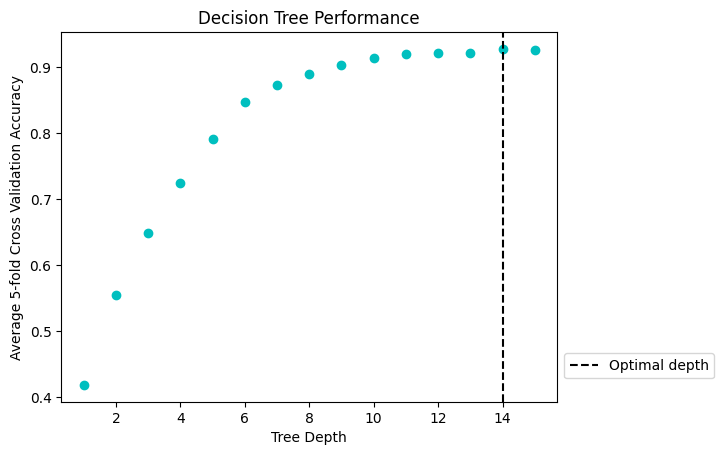

In [ ]:
# Decision tree classifier implementation:

# List of values to determine best tree depth:
D_range = np.arange(1,16)

# List to store the accuracy for each value of max_depth:
accuracy = []

# Perform desicion tree 5-fold cross-validation:
for depth in D_range:
    dtc = DecisionTreeClassifier(max_depth = depth,random_state = 0)
    dtc.fit(train_x, train_y)
    score = cross_val_score(dtc, train_x, train_y, cv=5, scoring='accuracy').mean()
    accuracy.append(score)

# Save depth at which highest accuracy was achieved:
max_y = max(accuracy)

# Plot cross-validation accuracy:
plt.plot(D_range,accuracy,'o', color = 'c')
plt.title('Decision Tree Performance')
plt.xlabel('Tree Depth')
plt.ylabel('Average 5-fold Cross Validation Accuracy')
best_D = D_range[accuracy.index(max_y)] # Find the x value corresponding to the maximum y value
plt.axvline(x= best_D, color="k", linestyle="--", label = "Optimal depth")
plt.legend(bbox_to_anchor = (1, 0.15))

In [ ]:
# Determine optimal tree depth from plot above and create decision tree:
dtc = DecisionTreeClassifier(max_depth = best_D, random_state = 0) #34
dtc.fit(train_x, train_y)

print("Max Cross-Validation Score of Decision Tree: ", max_y)
print('-'*40)
print("Decision Tree Accuracy on Training Data: ", dtc.score(train_x, train_y))
print('-'*40)
print("Decision Tree Accuracy on Validation Data: ", dtc.score(val_x, val_y))
print('-'*40)
print("Decision Tree Accuracy on Test Data: ", dtc.score(test_x, test_y))

Max Cross-Validation Score of Decision Tree:  0.9272918789346486
----------------------------------------
Decision Tree Accuracy on Training Data:  0.998458071403155
----------------------------------------
Decision Tree Accuracy on Validation Data:  0.9400544959128065
----------------------------------------
Decision Tree Accuracy on Test Data:  0.926669576604103


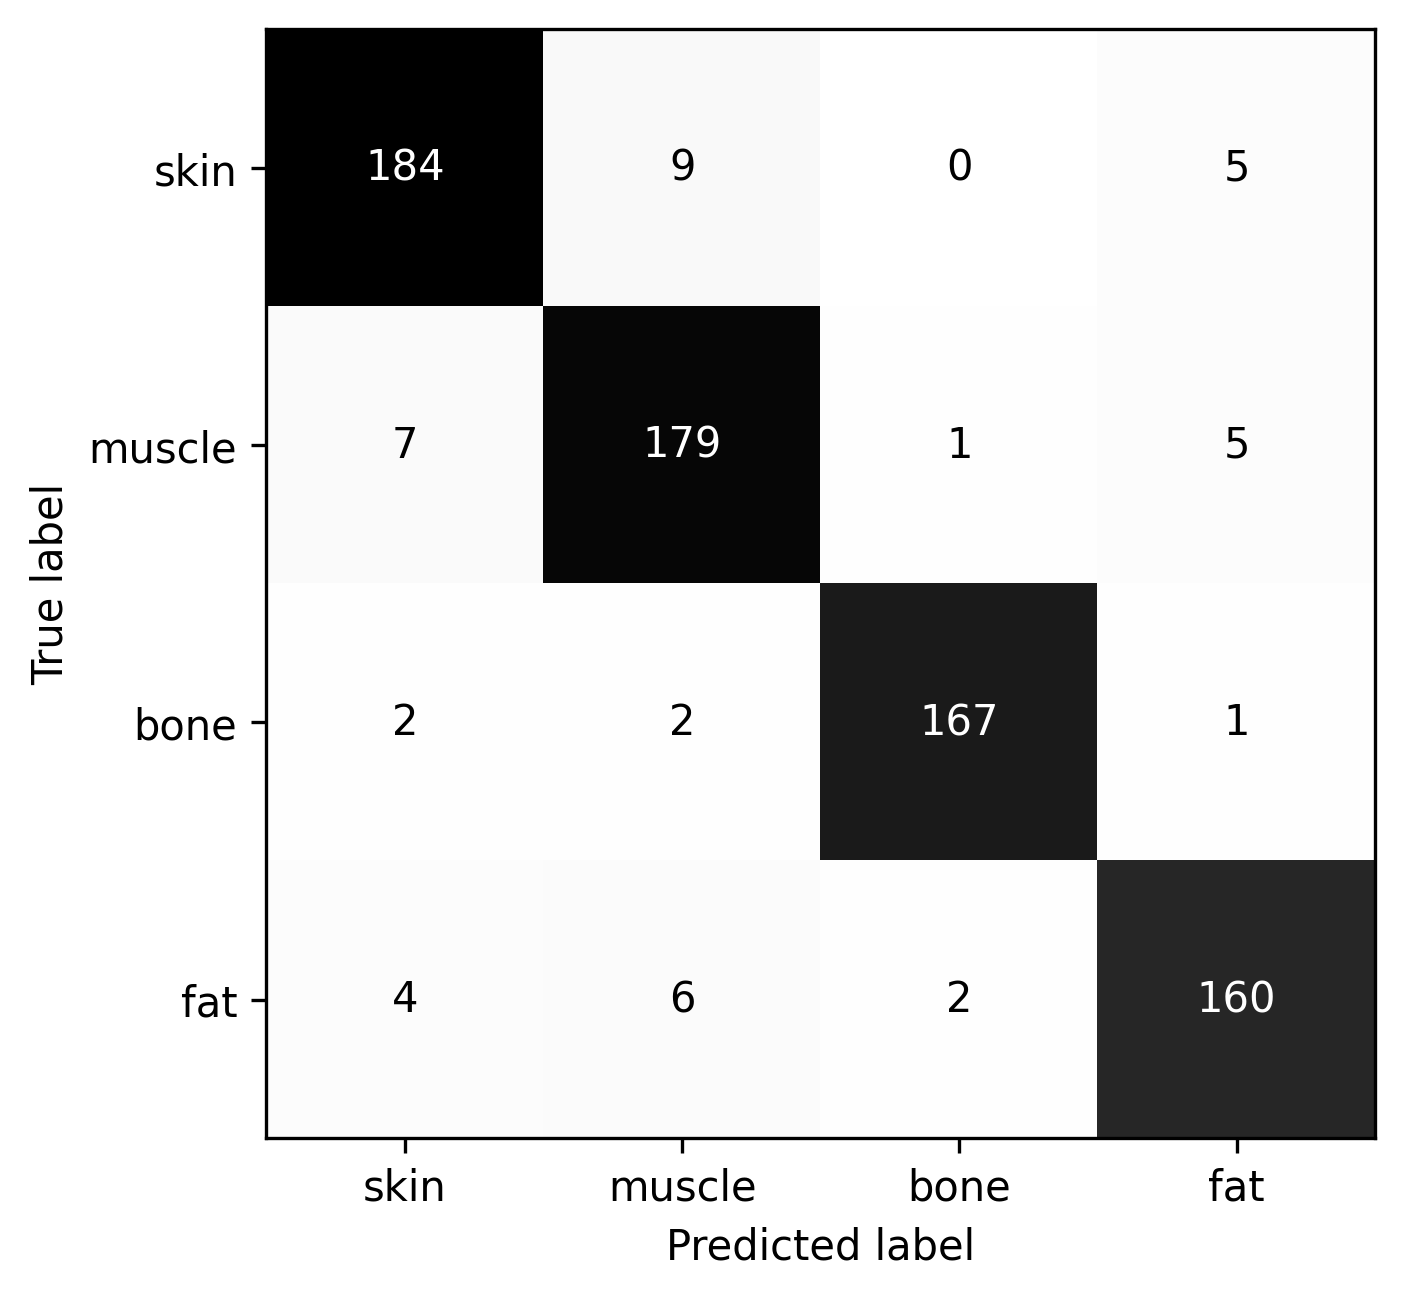

In [ ]:
# Test model accuracy on entire validation dataset:
DTCtrue_V_labels = val_y
DTCpred_V_labels = dtc.predict(val_x)

# Create confusion matrix to see true and false positives and corresponding tissue type:
create_confusion_matrix(DTCtrue_V_labels, DTCpred_V_labels)

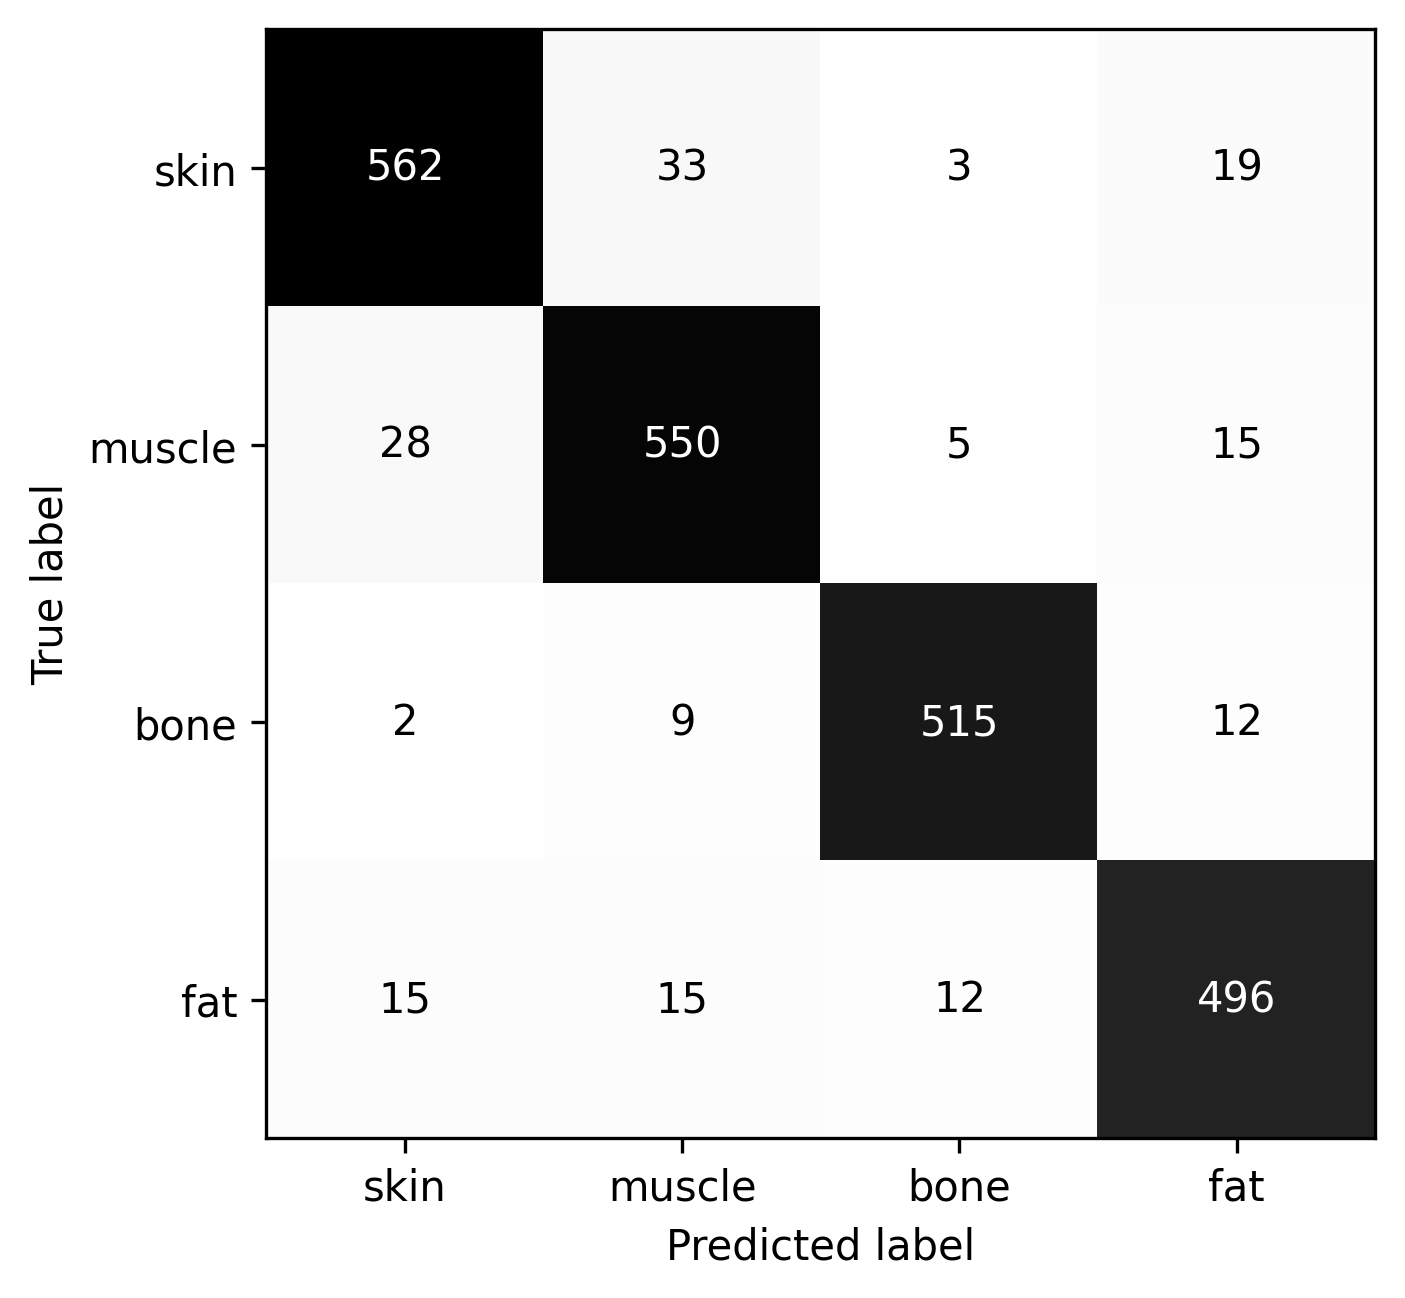

In [ ]:
# Test model accuracy on entire unseen test dataset:
DTCtrue_labels = test_y
DTCpred_labels = dtc.predict(test_x)

# Create confusion matrix to see true and false positives and corresponding tissue type:
create_confusion_matrix(DTCtrue_labels, DTCpred_labels)

### Random Forest Classifier

**Note**: must run decision tree classifier first

In [ ]:
# Create random forest classifier and fit to training data:
rfc = RandomForestClassifier(max_depth = best_D, random_state = 0)
rfc.fit(train_x, train_y)

print("Max Cross-Validation Score of Decision Tree: ", max_y)
print('-'*40)
print("Random Forest Accuracy on Training Data: ", rfc.score(train_x, train_y))
print('-'*40)
print("Random Forest Accuracy on Validation Data: ", rfc.score(val_x, val_y))
print('-'*40)
print("Random Forest Accuracy on Test Data: ", rfc.score(test_x, test_y))

Max Cross-Validation Score of Decision Tree:  0.9272918789346486
----------------------------------------
Random Forest Accuracy on Training Data:  1.0
----------------------------------------
Random Forest Accuracy on Validation Data:  0.9918256130790191
----------------------------------------
Random Forest Accuracy on Test Data:  0.9864687909209952


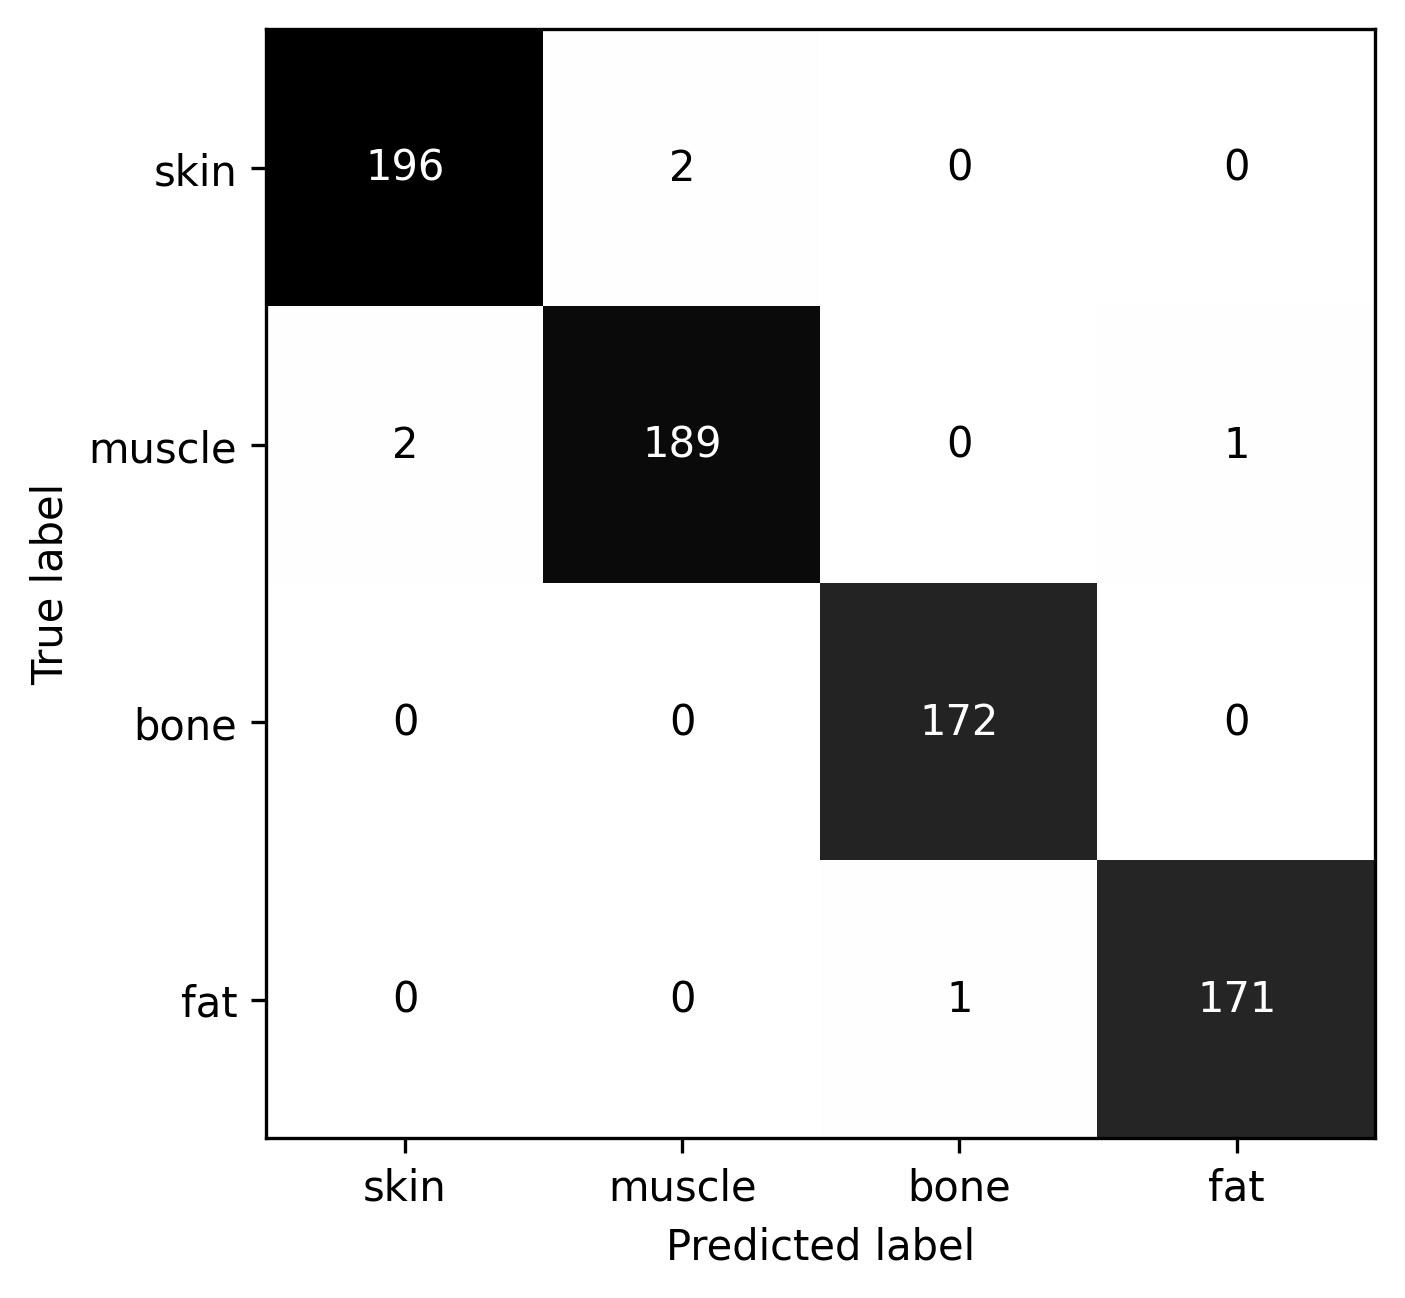

In [ ]:
# Test model accuracy on entire validation dataset:
RFCtrue_labels = val_y
RFCpred_labels = rfc.predict(val_x)

# Create confusion matrix to see true and false positives and corresponding tissue type:
create_confusion_matrix(RFCtrue_labels, RFCpred_labels)

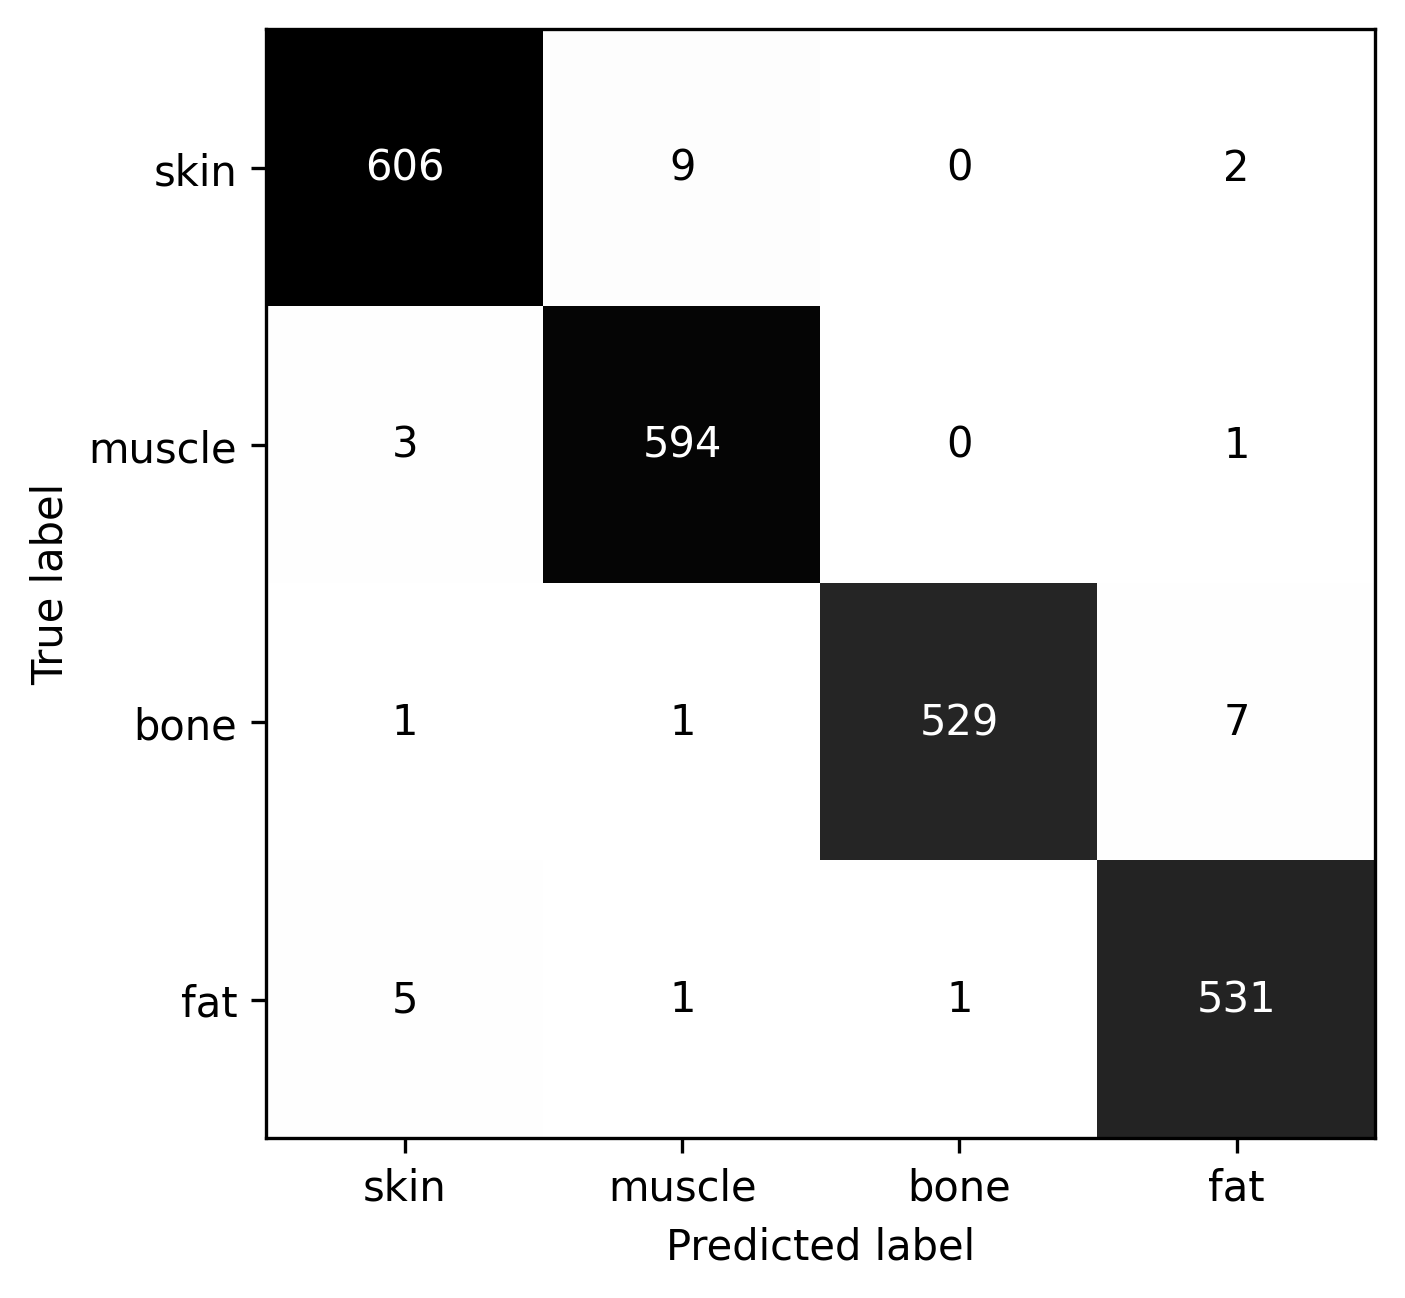

In [ ]:
# Test model accuracy on entire test dataset:
RFCtrue_V_labels = test_y
RFCpred_V_labels = rfc.predict(test_x)

# Create confusion matrix to see true and false positives and corresponding tissue type:
create_confusion_matrix(RFCtrue_V_labels, RFCpred_V_labels)

### K Nearest Neighbor

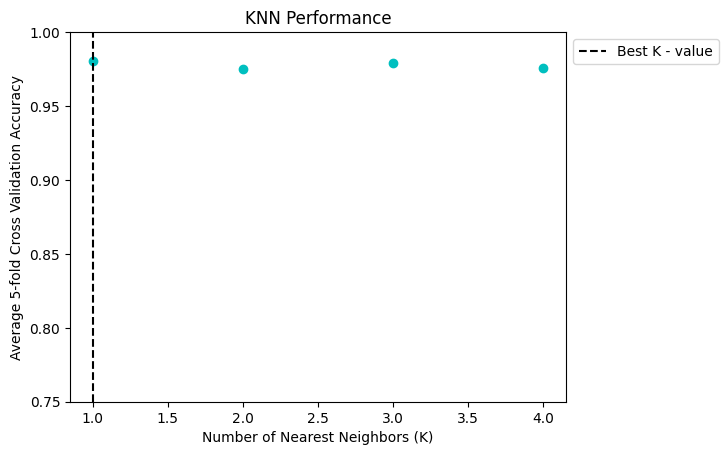

In [ ]:
# K Nearest Neighbor classifier implementation:

# Range of nearest neighbors K = 1 through K = 4:
k_range = np.arange(1,5)

# Use 5-fold cross-validation to compare the accuracy of KNN Classifier:
knnCVPerformance = np.zeros(len(k_range))
for K in k_range:
    knn = KNeighborsClassifier(n_neighbors=K)
    scores = cross_val_score(knn, train_x, train_y, cv=5, scoring='accuracy')
    knnCVPerformance[K-1] = scores.mean()

# Plot cross-validation accuracy:
plt.plot(k_range, knnCVPerformance, 'o', color = 'c')
plt.title("KNN Performance")
plt.xlabel('Number of Nearest Neighbors (K)')
plt.ylabel('Average 5-fold Cross Validation Accuracy')
max_x = k_range[knnCVPerformance.argmax()]  # Find the x value corresponding to the maximum y value
plt.axvline(x= max_x, color="k", linestyle="--", label = "Best K - value")
plt.ylim(.75, 1)
plt.legend(bbox_to_anchor = (1, 1))

In [ ]:
# Fit the model with best k-value from plot above using sklearn:
k = max_x
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_x, train_y)


print("Max Cross-Validation Score of K Nearest Neighbor: ", max_y)
print('-'*40)
print("K Nearest Neighbor Accuracy on Training Data: ", knn.score(train_x, train_y))
print('-'*40)
print("K Nearest Neighbor Accuracy on Validation Data: ", knn.score(val_x, val_y))
print('-'*40)
print("K Nearest Neighbor Accuracy on Test Data: ", knn.score(test_x, test_y))

Max Cross-Validation Score of K Nearest Neighbor:  0.9272918789346486
----------------------------------------
K Nearest Neighbor Accuracy on Training Data:  1.0
----------------------------------------
K Nearest Neighbor Accuracy on Validation Data:  0.9836512261580381
----------------------------------------
K Nearest Neighbor Accuracy on Test Data:  0.9786119598428634


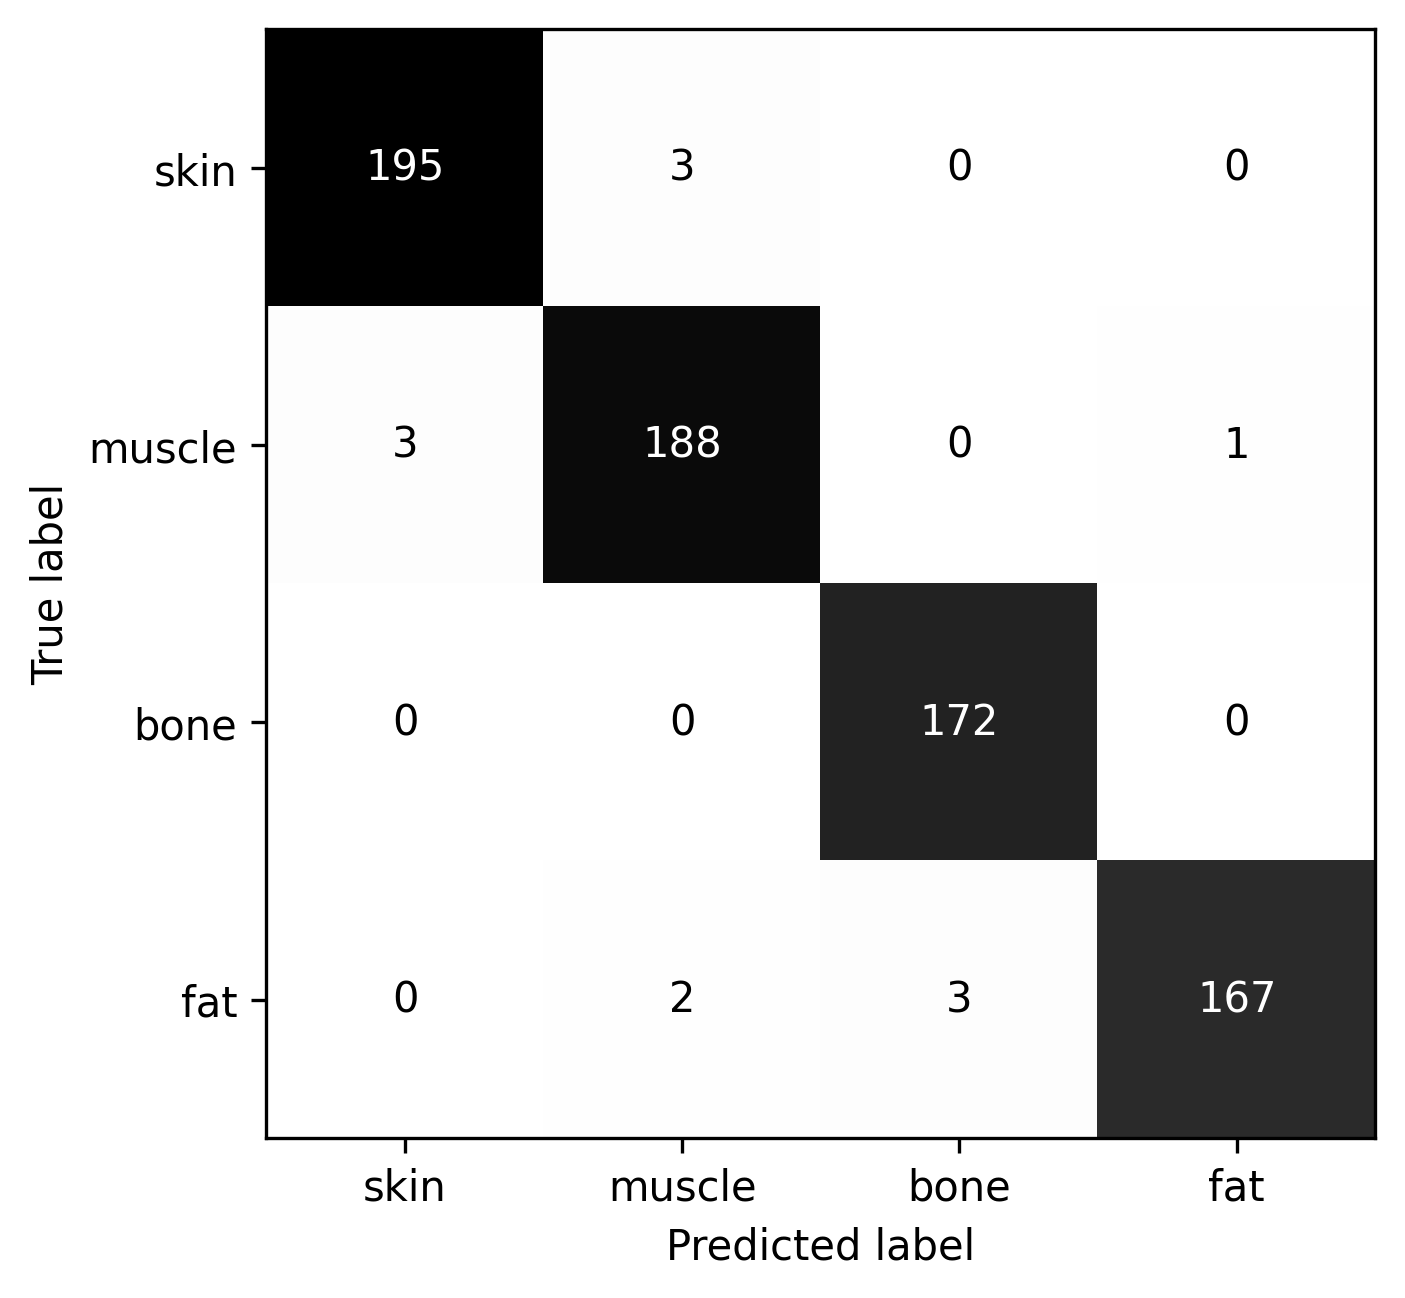

In [ ]:
# Test model accuracy on validation dataset:
KNNtrue_V_labels = val_y
KNNpred_V_labels = knn.predict(val_x)

# Create confusion matrix to see true and false positives and corresponding tissue type:
create_confusion_matrix(KNNtrue_V_labels, KNNpred_V_labels)

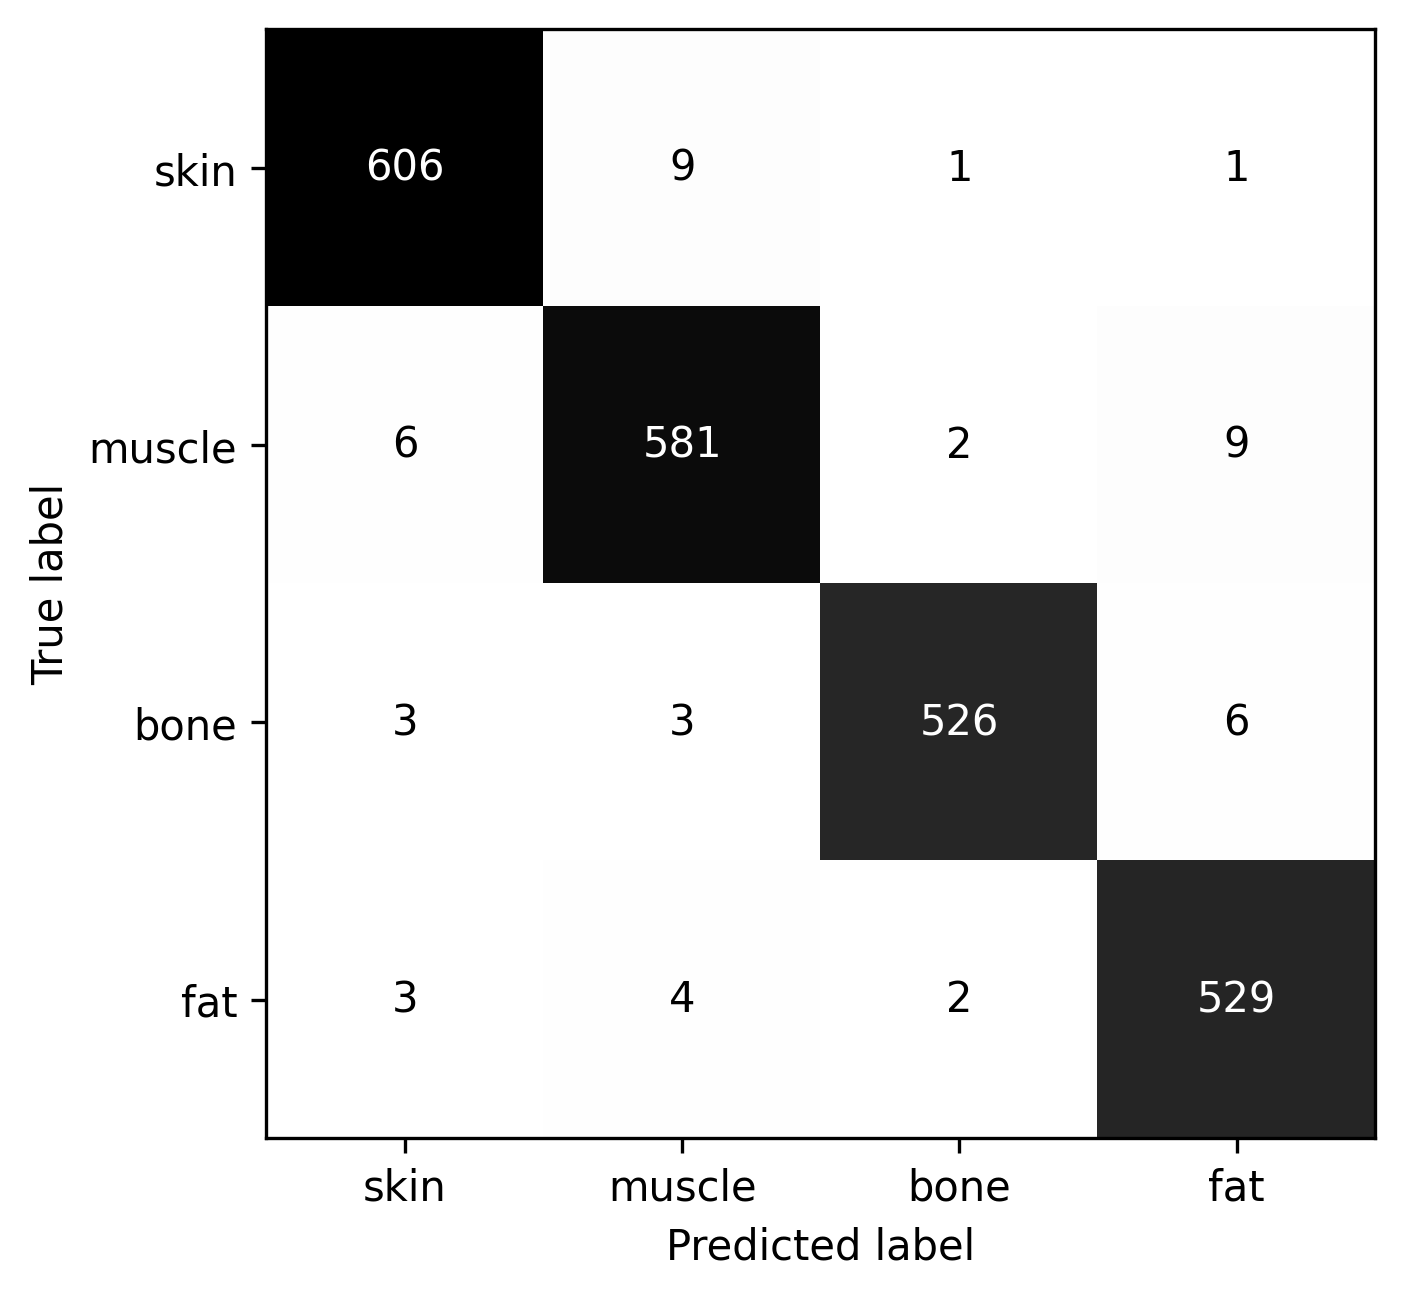

In [ ]:
# Test model accuracy on test dataset:
KNNtrue_labels = test_y
KNNpred_labels = knn.predict(test_x)

# Create confusion matrix to see true and false positives and corresponding tissue type:
create_confusion_matrix(KNNtrue_labels, KNNpred_labels)

### Neural Network Classifier

In [ ]:
# Deep Neural Network classifier implementation:

# Input dimensions of dataset:
num_classes = 4

# Assign tissues numerical labels:
NNtrain_y_s = (train_y == 'skin')*0
NNtrain_y_m = (train_y == 'muscle')*1
NNtrain_y_b = (train_y == 'bone')*2
NNtrain_y_f = (train_y == 'fat')*3
NNtrain_y = NNtrain_y_s + NNtrain_y_m + NNtrain_y_b + NNtrain_y_f

NNtest_y_s = (test_y == 'skin')*0
NNtest_y_m = (test_y == 'muscle')*1
NNtest_y_b = (test_y == 'bone')*2
NNtest_y_f = (test_y == 'fat')*3
NNtest_y = NNtest_y_s + NNtest_y_m + NNtest_y_b + NNtest_y_f

NNvalidation_y_s = (val_y == 'skin')*0
NNvalidation_y_m = (val_y == 'muscle')*1
NNvalidation_y_b = (val_y == 'bone')*2
NNvalidation_y_f = (val_y == 'fat')*3
NNvalidation_y = NNvalidation_y_s + NNvalidation_y_m + NNvalidation_y_b + NNvalidation_y_f

# Generate columns for output:
NNtrain_y = tf.keras.utils.to_categorical(NNtrain_y, num_classes)
NNtest_y = tf.keras.utils.to_categorical(NNtest_y, num_classes)
NNvalidation_y = tf.keras.utils.to_categorical(NNvalidation_y, num_classes)

NNtrain_x= np.asarray(train_x).astype('float32')
NNvalidation_x= np.asarray(val_x).astype('float32')
NNtest_x = test_data.iloc[:,2:]

In [ ]:
n_nodes = 100 #@param {type: "integer"}
n_hidden_layers = 3 #@param {type: "integer"}
dropout = 0.4 #@param {type: "number"}
# Define a sequential model for Deep Neural Network (DNN):
model = models.Sequential()
# Define input shape and activation:
model.add(Dense(n_nodes, input_shape=(train_x.shape[1],), activation='relu'))
# Normalize data:
model.add(layers.BatchNormalization())
# Add more dense layers:
for _ in range(n_hidden_layers):
    model.add(Dense(n_nodes, activation='relu'))
# Apply dropout rate then add another dense layer:
model.add(layers.Dropout(dropout))
model.add(Dense(num_classes, activation='softmax')) # softmax for classification

In [ ]:
# Compile model and set optimizer and metrics:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy']) # Adam, SGD,...

In [ ]:
# Define training parameters:
batch_size = 128 #@param {type: "integer"}
epochs = 50 #@param {type: "integer"}

base_path = '/content/drive/MyDrive/Research/Berkeley-France/'
model_file_label = 'july_combined' #@param {type: "string"} ["july_oes_only", "july_em_only", "july_combined"]
# best_model_path = f'{base_path}Mesbah Lab/model-checkpoints/{model_file_label}-batch{batch_size}-nodes{n_nodes}-layers{n_hidden_layers}.h5'
# save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss',
#                                   save_best_only=True, save_weights_only=True)

best_model_path = f"./data/tmp/{model_file_label}-batch{batch_size}-nodes{n_nodes}-layers{n_hidden_layers}.h5"
save_best_model = ModelCheckpoint(
    best_model_path, monitor="val_loss", save_best_only=True, save_weights_only=True
)

# Train DNN and store training info in history:
history = model.fit(
    NNtrain_x,
    NNtrain_y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(NNvalidation_x,NNvalidation_y),
    callbacks=[save_best_model],
)

model.load_weights(best_model_path)

Epoch 1/50
66/66 [==============================] - 4s 40ms/step - loss: 0.6252 - accuracy: 0.7617 - val_loss: 78.6989 - val_accuracy: 0.2343
Epoch 2/50
66/66 [==============================] - 2s 26ms/step - loss: 0.1368 - accuracy: 0.9560 - val_loss: 40.8250 - val_accuracy: 0.4946
Epoch 3/50
66/66 [==============================] - 1s 21ms/step - loss: 0.0598 - accuracy: 0.9816 - val_loss: 13.9169 - val_accuracy: 0.4523
Epoch 4/50
66/66 [==============================] - 2s 24ms/step - loss: 0.0750 - accuracy: 0.9764 - val_loss: 16.9104 - val_accuracy: 0.2602
Epoch 5/50
66/66 [==============================] - 2s 33ms/step - loss: 0.0376 - accuracy: 0.9880 - val_loss: 12.0588 - val_accuracy: 0.2384
Epoch 6/50
66/66 [==============================] - 2s 26ms/step - loss: 0.0316 - accuracy: 0.9890 - val_loss: 1.2966 - val_accuracy: 0.6458
Epoch 7/50
66/66 [==============================] - 1s 20ms/step - loss: 0.0369 - accuracy: 0.9879 - val_loss: 5.5850 - val_accuracy: 0.5123
Epoch 8/

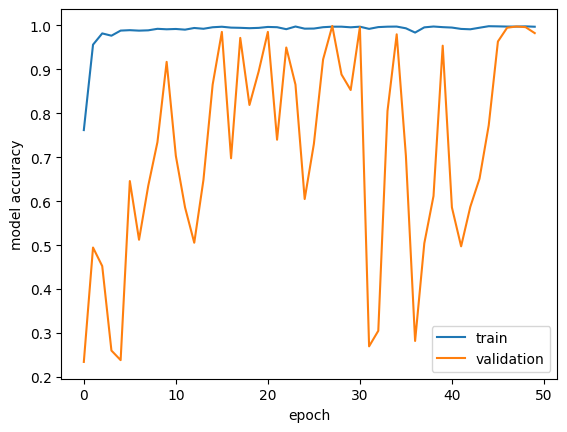

In [ ]:
# Plot training history based on model accuracy:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
# Evaluate model on training set:
print('evaluating model on training data ...')
score = model.evaluate(NNtrain_x, NNtrain_y, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# Evaluate model on validation set:
print('evaluating model on validation data ...')
score = model.evaluate(NNvalidation_x, NNvalidation_y, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

# Evaluate model on unseen test set:
print('evaluating model on unseen test data ...')
score = model.evaluate(NNtest_x, NNtest_y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

evaluating model on training data ...
264/264 [==============================] - 1s 3ms/step - loss: 0.0053 - accuracy: 0.9976
Train loss: 0.005250352434813976
Train accuracy: 0.9976277947425842
evaluating model on validation data ...
23/23 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 0.9973
Validation loss: 0.005873566493391991
Validation accuracy: 0.9972752332687378
evaluating model on unseen test data ...
72/72 [==============================] - 0s 4ms/step - loss: 0.0071 - accuracy: 0.9969
Test loss: 0.0070619238540530205
Test accuracy: 0.9969445466995239


23/23 [==============================] - 0s 4ms/step


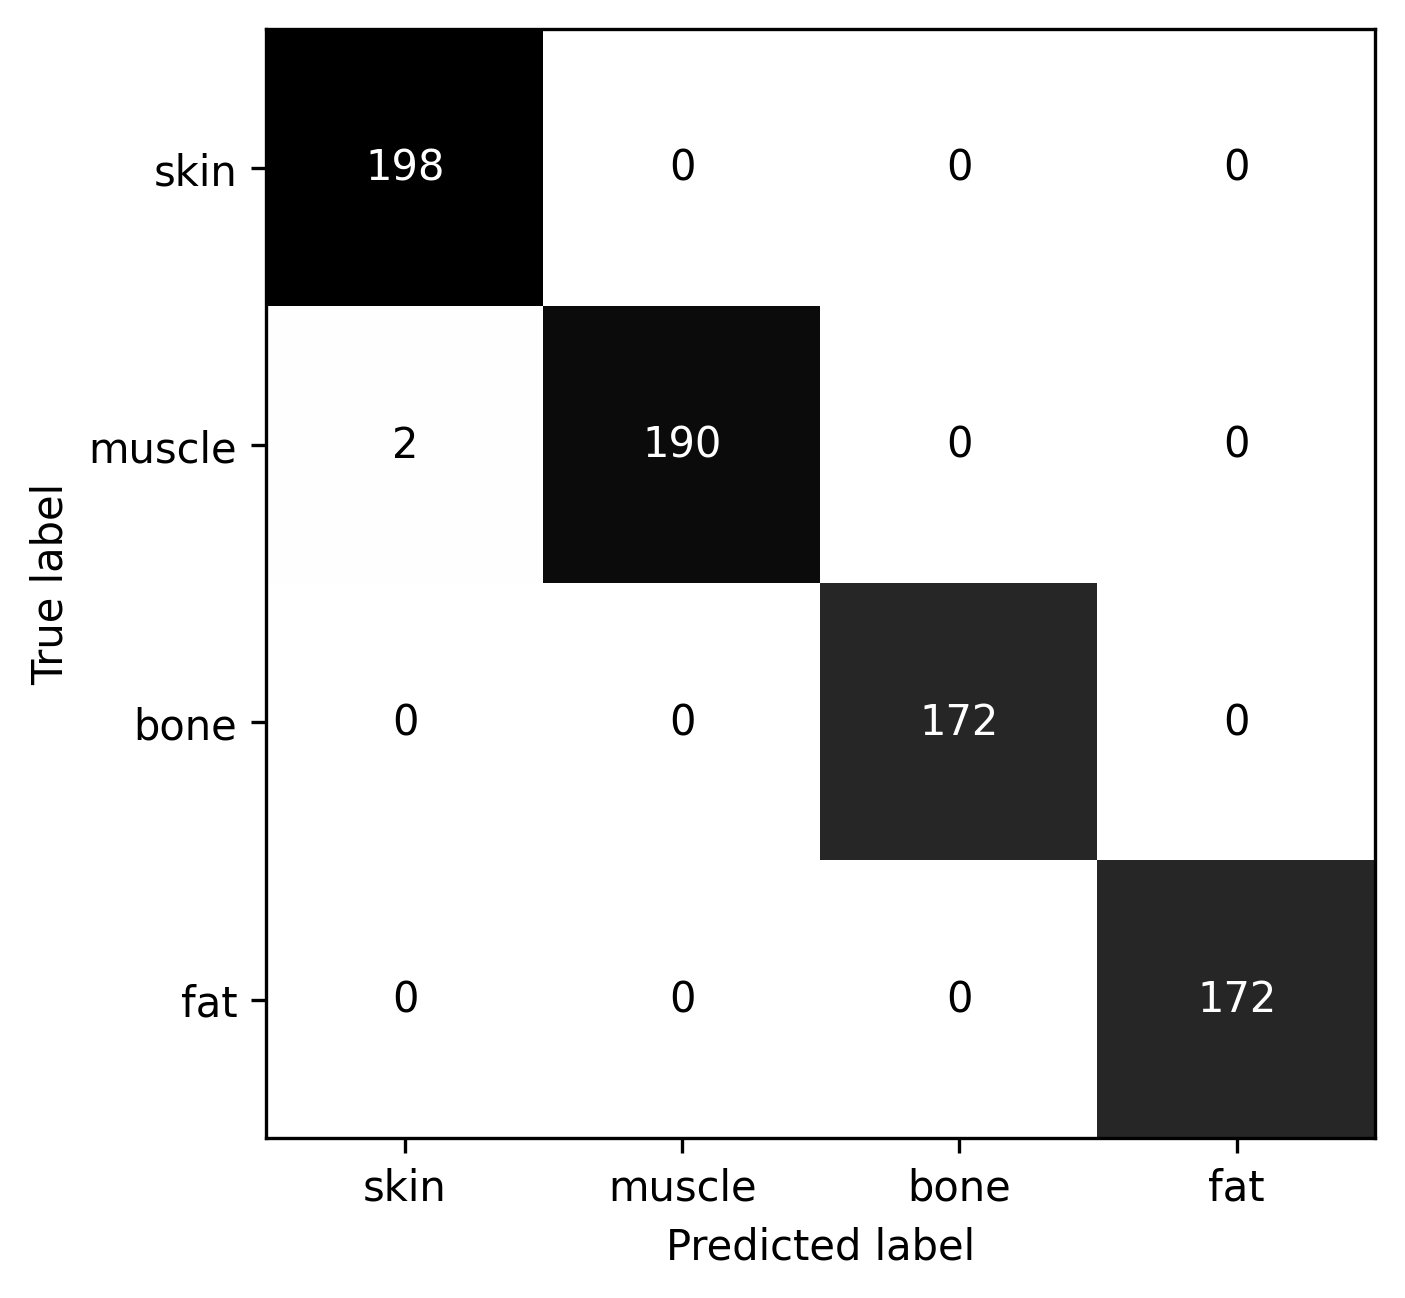

In [ ]:
# Get model predictions on validation data
NNtrue_V_labels = np.argmax(NNvalidation_y, axis=1)
NNpred_V_labels = model.predict(NNvalidation_x)
NNpred_V_labels = np.argmax(np.round(NNpred_V_labels), axis=1)
# Create confusion matrix to see true and false positives and corresponding tissue type:
c = create_confusion_matrix(NNtrue_V_labels, NNpred_V_labels, labels=[0,1,2,3])

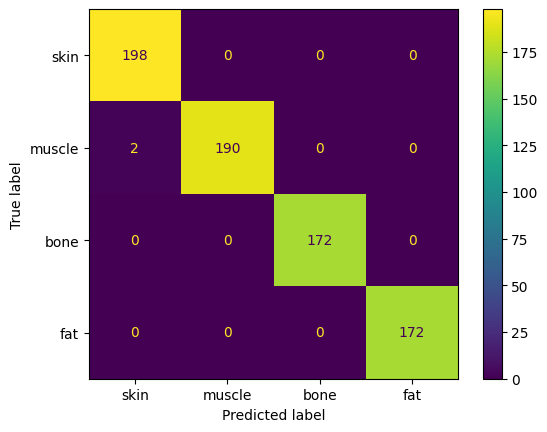

In [ ]:
c.figure_.colorbar(c.im_,c.ax_)
c.plot()

72/72 [==============================] - 0s 4ms/step


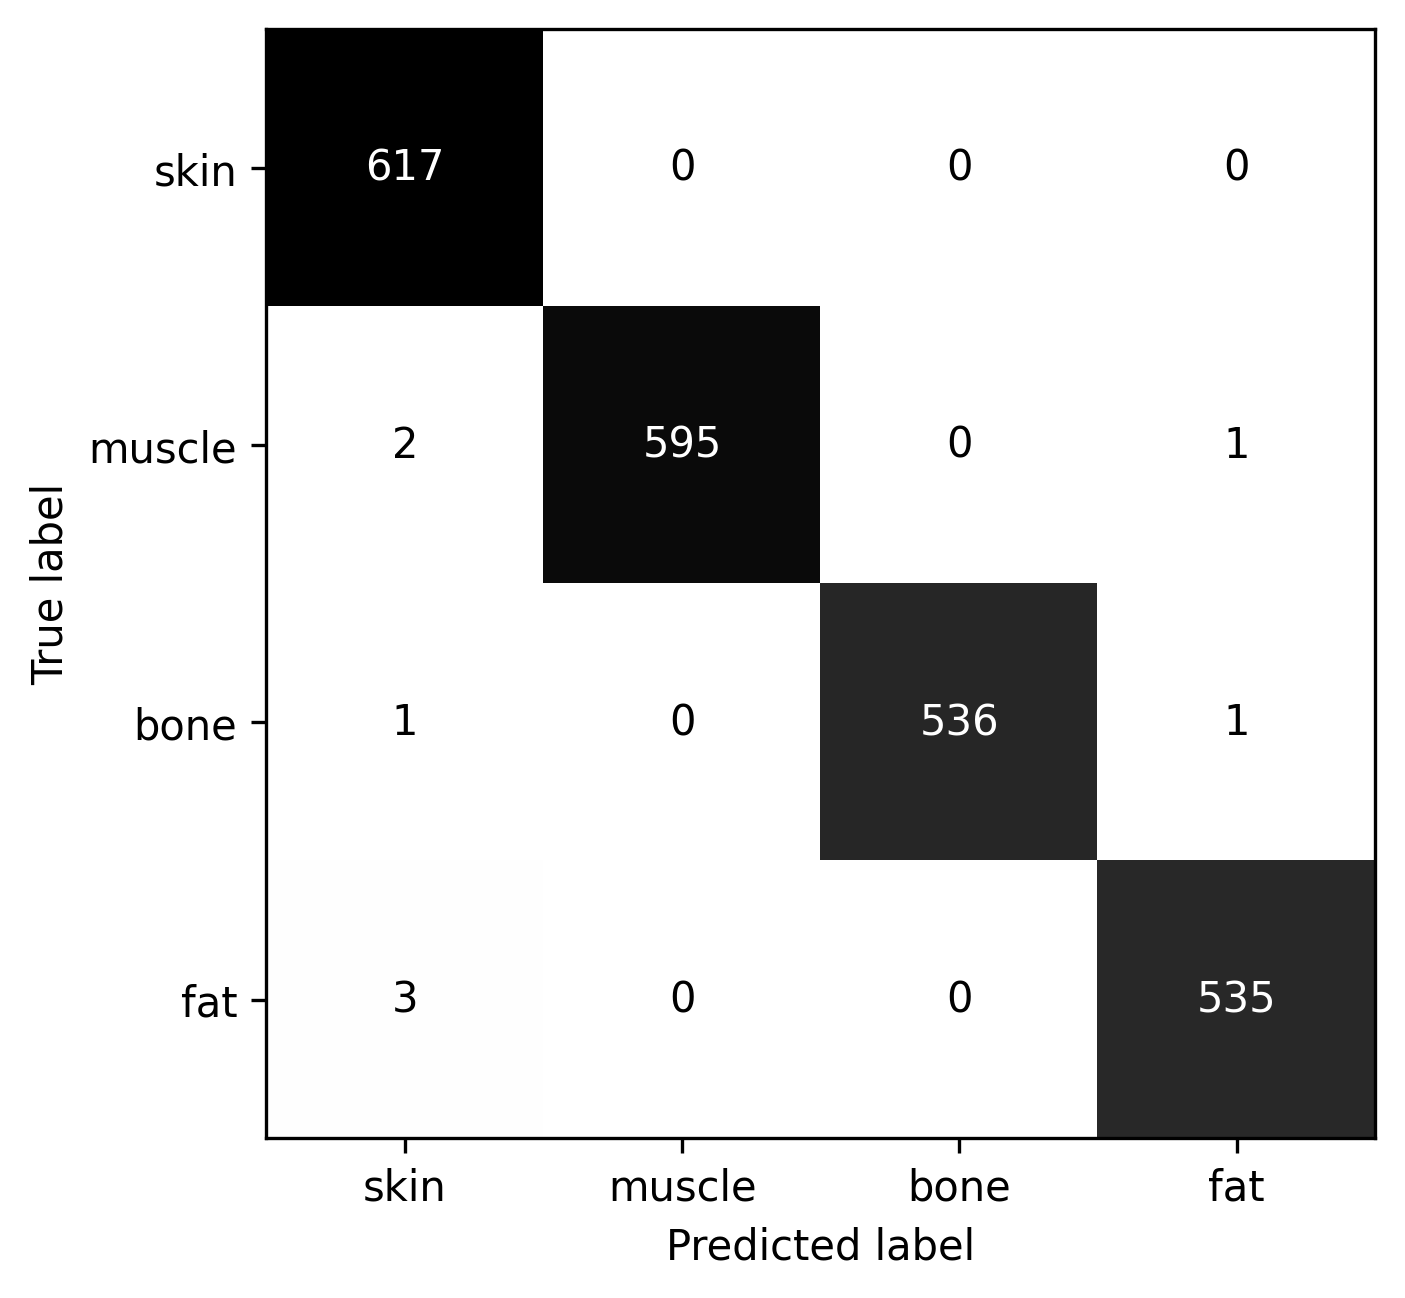

In [ ]:
# get model predictions for test data
NNtrue_labels = np.argmax(NNtest_y, axis=1)
NNpred_labels = model.predict(NNtest_x)
NNpred_labels = np.argmax(np.round(NNpred_labels), axis=1)
# Create confusion matrix to see true and false positives and corresponding tissue type:
create_confusion_matrix(NNtrue_labels, NNpred_labels, labels=[0,1,2,3])